In [28]:
# ica_audio.py
# Author: Slim Essid
import pylab as pl
import numpy as np
import wave
from sklearn import decomposition
import matplotlib.pyplot as plt
from scipy.io import wavfile

In [3]:
# -- Read audio data ----------------------------------------------------------
def wavread(filename):
    wf = wave.open(filename)
    s = np.fromstring(wf.readframes(wf.getnframes()), dtype=np.int16)
    wf.close()
    return s


def wavwrite(filename, s, nchannels=1):
    wf = wave.open(filename,'wb')
    wf.setnchannels(nchannels)
    wf.setsampwidth(2)
    wf.setframerate(32000)
    s = s/max(abs(s))*2**14 # normalise arbitrarily
    wf.writeframes(s.astype(np.int16).tostring())
    wf.close()


In [4]:
s1 = wavread('2snd/snd/es02.wav')
s2 = wavread('2snd/snd/si01.wav')

/home/parfait/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  after removing the cwd from sys.path.


In [5]:
print(s1)

[0 0 0 ... 0 0 0]


In [6]:
print(s2)

[  0   0   0 ... -75 -75 -75]


In [7]:
# -- Create stereo mix ---------------------------------------------------------
nsmp = min(len(s1), len(s2))
s1 = s1[:nsmp]
s2 = s2[:nsmp]
S = np.c_[s1, s2]

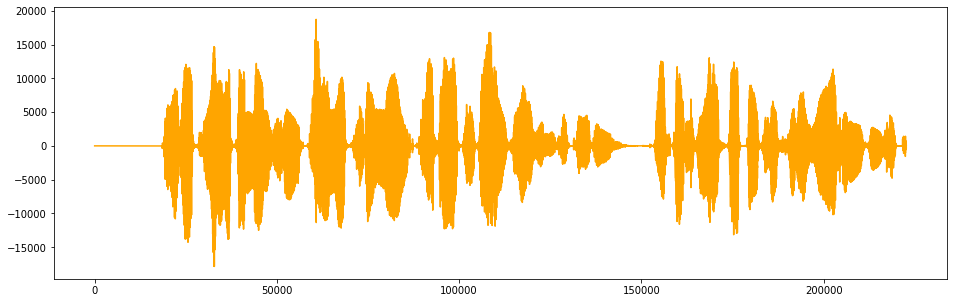

In [8]:
plt.figure(figsize=(16, 5))
plt.plot(s1, color='orange')

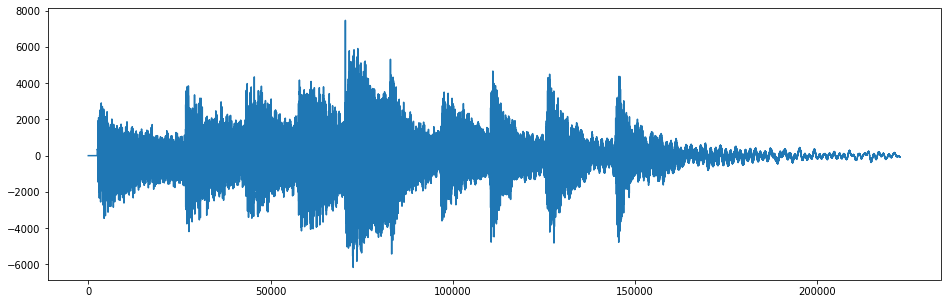

In [9]:
plt.figure(figsize=(16, 5))
plt.plot(s2)

In [10]:
S

array([[   0,    0],
       [   0,    0],
       [   0,    0],
       ...,
       [-186,  -75],
       [-117,  -75],
       [  60,  -75]], dtype=int16)

In [11]:
# Mixing matrix
A = np.array([ [0.6, 0.5],[0.4, 0.5]])
# Do the mix
X = S.dot(A)

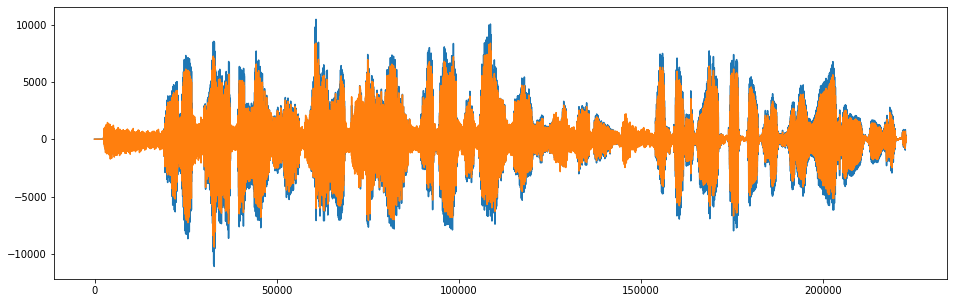

In [12]:
plt.figure(figsize=(16, 5))
plt.plot(X)

In [13]:
# Write mix file
x = np.zeros(2*nsmp)
x[::2] = X[:,0]
x[1::2] = X[:,1]
wavwrite('2snd/snd/mix.wav', x, nchannels=2)

In [14]:
s_mix = wavread('2snd/snd/mix.wav')

/home/parfait/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  after removing the cwd from sys.path.


In [43]:
s_mix.shape

(445396,)

In [44]:
transformer = decomposition.FastICA(n_components=2)
S_ = transformer.fit_transform(X)
S_.shape

(222698, 2)

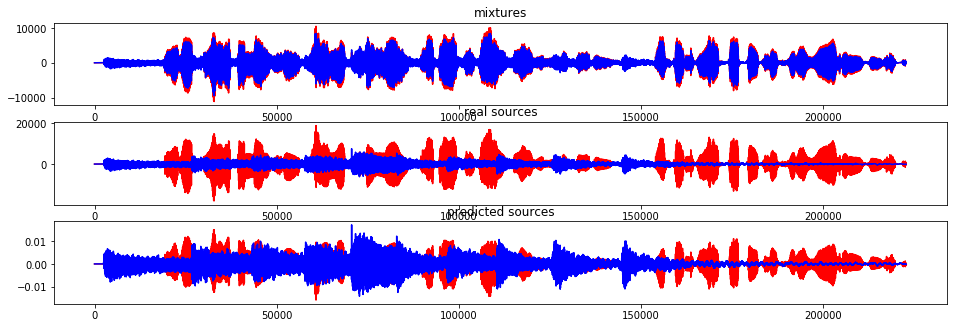

In [45]:
plt.figure(figsize=(16, 7))
models = [X, S, S_]
names = ['mixtures', 'real sources', 'predicted sources']
colors = ['red', 'blue', 'orange']
for i, (name, model) in enumerate(zip(names, models)):
    plt.subplot(4, 1, i+1)
    plt.title(name)
    for sig, color in zip (model.T, colors):
        plt.plot(sig, color=color)
fig.tight_layout()        
plt.show()

In [48]:
wavwrite('2snd/snd/out1.wav', S_[:,0])
wavwrite('2snd/snd/out2.wav', S_[:,1])

### - E XTRACTION DE CARACTÉRISTIQUES DE VISAGES -

In [62]:
# pca_nmf_faces.py
# Authors: Vlad Niculae, Alexandre Gramfort, Slim Essid
# License: BSD
from time import time
from numpy.random import RandomState
import pylab as pl
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn import decomposition

In [73]:
# -- Prepare data and define utility functions ---------------------------------
n_row, n_col = 2, 5
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

In [74]:
# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data
n_samples, n_features = faces.shape

In [75]:
# global centering
faces_centered = faces - faces.mean(axis=0, dtype=np.float64)

In [76]:
print("Dataset consists of %d faces" % n_samples)

Dataset consists of 400 faces


In [79]:
def plot_gallery(title, images):
    pl.figure(figsize=(2. * n_col, 2.26 * n_row))
    pl.suptitle(title, size=16)
    for i, comp in enumerate(images):
        pl.subplot(n_row, n_col, i + 1)
        comp = comp.reshape(image_shape)
        vmax = comp.max()
        vmin = comp.min()
        dmy = np.nonzero(comp<0)
        
        if len(dmy[0])>0:
            yz, xz = dmy
            
        comp[comp<0] = 0
        pl.imshow(comp, cmap=pl.cm.gray, vmax=vmax, vmin=vmin)
        
            #print "vmax: %f, vmin: %f" % (vmax, vmin)
            #print comp
        if len(dmy[0])>0:
            pl.plot( xz, yz, 'r,')
            print(len(dmy[0]), "negative-valued pixels")
            
        pl.xticks(())
        pl.yticks(())
        
    pl.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

2773 negative-valued pixels
2630 negative-valued pixels
1422 negative-valued pixels
1242 negative-valued pixels
1004 negative-valued pixels
2049 negative-valued pixels
1580 negative-valued pixels
1387 negative-valued pixels
3819 negative-valued pixels


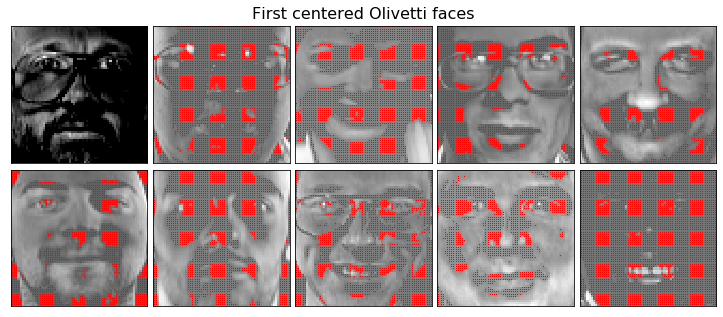

In [80]:
# Plot a sample of the input data
gall = plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

In [89]:
# List of the different estimators and whether to center the data
estimators = [('pca', 'Eigenfaces - PCA',decomposition.PCA(n_components=n_components, whiten=True),True),('nmf', 'Non-negative components - NMF',
decomposition.NMF(n_components=n_components, init=None, tol=1e-6,max_iter=2000),False)]

Extracting the top 10 Eigenfaces - PCA...
done in 2.745s
3998 negative-valued pixels
2078 negative-valued pixels
1967 negative-valued pixels
1862 negative-valued pixels
2261 negative-valued pixels
1924 negative-valued pixels
1951 negative-valued pixels
1883 negative-valued pixels
2222 negative-valued pixels
2127 negative-valued pixels
Extracting the top 10 Non-negative components - NMF...
done in 187.761s


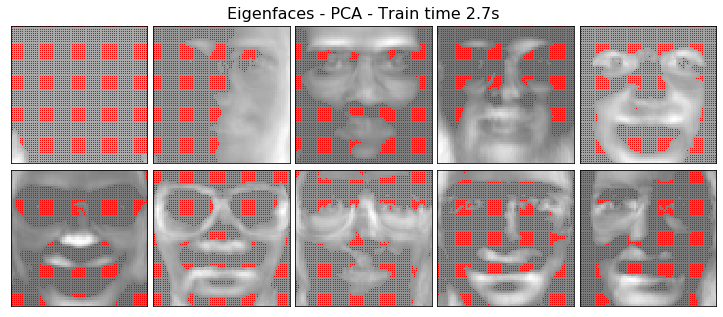

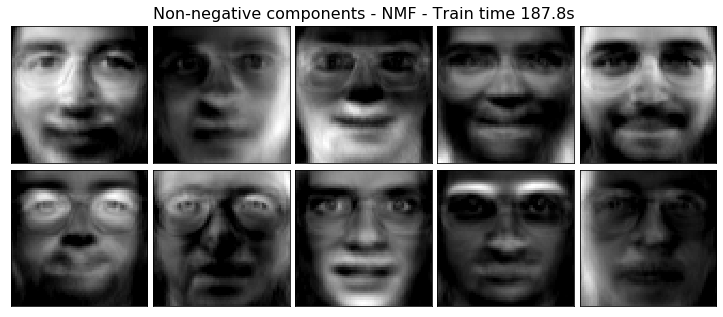

In [90]:
# -- Transform and classify ----------------------------------------------------
labels = dataset.target
X = faces
X_ = faces_centered
for shortname, name, estimator, center in estimators:
    #if shortname != 'nmf': continue
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = X
    
    if center:
        data = X_
        
    data = estimator.fit_transform(data)
    
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    
    components_ = estimator.components_
    
    plot_gallery('%s - Train time %.1fs' % (name, train_time),components_[:n_components])

### - E XTRACTION DE THÈMES À PARTIR DE TEXTES -